In [1]:
#%load_ext line_profiler
#%%prun  -D train.prof -s cumulative -q -T prun0
#print(open('prun0', 'r').read())
#%snakeviz 1 + 2

In [2]:
#from torch.profiler import profile, record_function, ProfilerActivity
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("train_model"):
#        models, trainers = train_model(model_type, data_modules, model_args, verbose=True)
#prof.key_averages().table(sort_by="cuda_time_total", row_limit=10)

In [3]:
import os
import math
import random
import copy
        
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from data_utils import SeqDataModule

In [4]:
show_umap = False

if show_umap:
    # plot umap
    dm = data_modules[0]
    dm.setup()  # remove NaNs and normalize
    train_dl = dm.train_dataloader()
    train_inputs = train_dl.dataset.inputs
    train_targets = train_dl.dataset.targets

    from umap import UMAP
    import umap.plot

    flat_inputs = np.concatenate(train_inputs, axis=0)
    flat_targets = np.concatenate(train_targets, axis=0)
    mask = ~np.isnan(flat_targets)
    flat_inputs = flat_inputs[mask]
    flat_targets = flat_targets[mask]

    mapper = UMAP(n_components=2)
    umapped_inputs = mapper.fit_transform(flat_inputs)

    umap.plot.points(mapper, values=flat_targets, theme="fire")

In [5]:
# NaN filling debug plots

# plot data
#train_inputs = train_dl.dataset.inputs
#val_inputs = val_dl.dataset.inputs
#print("Lens train val:", len(train_inputs), len(val_inputs))


#pat_idx = 12
#feat_idx = 5

#feat_name = feature_names[feat_idx]
##print(model.mean[0, feat_idx])
#pat_data = train_inputs[pat_idx][:, feat_idx]
#print(pat_data.min())
#print(torch.isnan(pat_data).sum())
#plt.plot(pat_data)
##plt.title(f"Progression of {feat_name}")
#plt.ylabel(feat_name)
#plt.xlabel("time")

#nan_again = train_inputs[pat_idx][:, feat_idx]
#plt.scatter(range(len(nan_again)), nan_again)
#plt.show()
#print(np.isnan(nan_again).sum())
#print(nan_again.shape)

In [6]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [7]:
# hyperparams
args = {}
# data args
args["minutes"] = 60
args["norm_method"] = None # z, None
all_dbs = ["eICU", "UKE", "MIMIC"]
args["dbs"] = ["UKE"]  #"all" # ["eICU", "UKE", "MIMIC"], all
args["k_fold"] = 0
args["num_splits"] = 3
args["flat_block_size"] = 0
args["model_type"] = "xgb"
args["features"] = None

model_args = {}
# dataloader args
model_args["train_noise_std"] = 0.01
model_args["random_starts"] = True
model_args["min_len"] = 20
# preprocess args
model_args["fill_type"] = "pat_ema" # "pat_mean", "mean", "pat_ema" "pat_ema_mask"
# training args
model_args["max_steps"] = 200
model_args["val_check_interval"] = 100  # check validation performance every N steps
model_args["grad_clip_val"] = 1.0
#epochs = 10
model_args["lr"] = 0.0001
model_args["bs"] = 8
# model args
model_args["hidden_size"] = 512
model_args["dropout"] = 0.1
model_args["rnn_layers"] = 1
model_args["rnn_type"] = "gru"
#linear
model_args["alpha"] = 1
model_args["l1_ratio"] = 0.5
# xgb
model_args["n_estimators"] = 50
model_args["max_depth"] = 6 
model_args["min_child_weight"] = 1 # 1-inf
model_args["gamma"] = 0.0 # 0-inf
model_args["subsample"] = 1.0 # 0.0-1.0
model_args["colsample_bytree"] = 1.0 # 0.-1.0
model_args["tree_method"] = "gpu_hist" # hist, gpu_hist

args["seed"] = 2
seed = pl.utilities.seed.seed_everything(seed=args["seed"], workers=False)

In [8]:
from data_utils import get_seq_list, make_split, do_fold

# choose feats
#no_meds = [name for name in feature_names if "_Med" not in name and "Diagnose" not in name]
#args["features"] = no_meds # no_meds

# load data
seq_list = get_seq_list(args["minutes"], False, "ICP_Vital", args["features"])

# dev test split
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)
# train val splits
data_modules = do_fold(dev_data, test_data, 
                       args["dbs"], 
                       model_args["random_starts"], 
                       model_args["min_len"], 
                       model_args["train_noise_std"],
                       model_args["bs"],
                       model_args["fill_type"], 
                       args["flat_block_size"],
                       k_fold=args["k_fold"], 
                       num_splits=args["num_splits"],
                      )

train_dl = data_modules[0].train_dataloader()
val_dl = data_modules[0].val_dataloader()
num_features = train_dl.dataset.inputs[0].shape[-1]
feature_names = train_dl.dataset.feature_names

print(feature_names)

Reading df from:  data/60_/yeo_N/normalization_None/median/uni_clip_0.9999/multi_clip_N/df.pkl
['rel_time', 'AF_Vital', 'AF_Vital_max', 'AF_Vital_min', 'AF_Vital_std', 'ALT_Labor', 'AST_Labor', 'Alpha Blocker_Med', 'Benzodiazepin_Med', 'Ca_BGA', 'Cl_BGA', 'Direkter Vasodilatator_Med', 'EVB_Labor', 'FiO2_Vital', 'FiO2_Vital_std', 'Freq gesamt_Vital', 'Freq spontan_Vital', 'GCS_auge_Vital', 'GCS_motor_Vital', 'GCS_total_Vital', 'GCS_verbal_Vital', 'Glu_BGA', 'HCO3_BGA', 'HF_Vital', 'HF_Vital_max', 'HF_Vital_min', 'HF_Vital_std', 'Harnstoff-N_Labor', 'Hb_BGA_BGA', 'Hk_Labor', 'INR_Labor', 'K_BGA', 'Katecholamin_Med', 'Kreatinin_Labor', 'Lac_BGA', 'MCHC_Labor', 'MCH_Labor', 'MCV_Labor', 'Magnesium_Labor', 'Na_BGA', 'Narkotikum_Med', 'Opioid_Med', 'PCO2_BGA', 'PEEP_Vital', 'PO2_BGA', 'Phosphat_Labor', 'Pmean_Vital', 'Ppeak_Vital', 'Pupille li_Vital', 'Pupille re_Vital', 'SBE_BGA', 'SpO2_Vital', 'SpO2_Vital_max', 'SpO2_Vital_min', 'SpO2_Vital_std', 'TZ_Labor', 'Temp_Vital', 'Temp_Vital_std',

In [9]:
mean_train_target = np.concatenate([pat[~torch.isnan(pat)].numpy() for pat in train_dl.dataset.targets]).mean()#np.mean([pd.Series(pat).mean() for pat in train_dl.dataset.targets])
print("Mean train target: ", mean_train_target)

total_icps = np.sum([(~pd.Series(pat).isna()).sum() for pat in train_dl.dataset.targets])
total_steps = np.sum([len(pat) for pat in train_dl.dataset.targets])
print("Total steps: ", total_steps)
print("Total ICP training targets: ", total_icps)

Mean train target:  13.053722766145164
Total steps:  191068
Total ICP training targets:  150238


In [10]:
from data_utils import SequenceDataset, seq_pad_collate

external_db_names = [db for db in all_dbs if db not in args["dbs"]]
print("External validation dbs: ", external_db_names)
external_datasets = [SequenceDataset(seq_list, "ICP_Vital", train=False, random_starts=False, block_size=0, 
                         train_noise_std=0.0, dbs=[db]) for db in external_db_names]
external_dls = {db_name: torch.utils.data.DataLoader(ds, batch_size=model_args["bs"] * 4, collate_fn=seq_pad_collate) for db_name, ds in zip(external_db_names, external_datasets)}

External validation dbs:  ['eICU', 'MIMIC']


In [11]:
# train
#model_args["lr"] = 0.005
model_args["max_steps"] = 200

classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "transformer"]
# Choose:
model_type = "xgb" # ["linear", "xgb"], ["mlp", "rnn", "transformer"]

In [12]:
from train_utils import train_model

models, trainers = train_model(model_type, data_modules, model_args, verbose=False)

In [13]:
from data_utils import seq_pad_collate

def traini(bs, num_workers, pin):
    dl = torch.utils.data.DataLoader(data_modules[0].train_ds, batch_size=bs, num_workers=num_workers, pin_memory=pin, collate_fn=seq_pad_collate)
    model = create_model(model_type, data_modules[0], model_args)
    trainer = create_trainer(model_args, verbose=False)
    trainer.fit(model, dl)

In [14]:
from eval_utils import get_all_dfs, print_all_metrics

# eval
dl_type = "test"
dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
calc_new_norm_stats = True
dl = None

df = get_all_dfs(models, trainers, model_type, dl_type=dl_type, dl=dl, calc_new_norm_stats=calc_new_norm_stats)

In [15]:
print_all_metrics(df)

Performance over splits: 
            targets      preds      error
model_id                                 
0         13.203527  13.473685  77.723793
1         13.203527  13.675105  79.354236
2         13.203527  13.327634  80.902869
Mean train target:  13.053722766145164
Mean/Std preds:  13.598003 7.0178623
Mean/Std targets:  13.203526552941277 11.068664597496733
Max error:  7212.454410167935
Accuracy for hypertension baseline:  0.9147020163883994

Model metrics:
RMSE:  8.906568707631719
MSE:  79.32696614376455
MAE:  5.684785392040176
MAPE:  0.43055053278730354
R2 custom:  0.3525094622335089
R2:  0.35250946223350904
R2 old:  0.3525094622335089
Accuracy for hypertension:  0.9147020163883995
Precision for hypertension:  0.42127419417889067
Recall for hypertension:  0.33740853940909515

Mean train baseline metrics:
Mean train target: 13.053722766145164
RMSE:  11.06963958598189
MSE:  122.5369205635373
MAE:  6.338916477820832
MAPE:  0.4800926822394087
R2 custom:  -8.280620603306957
R2 sc

(0.0, 5000.0)

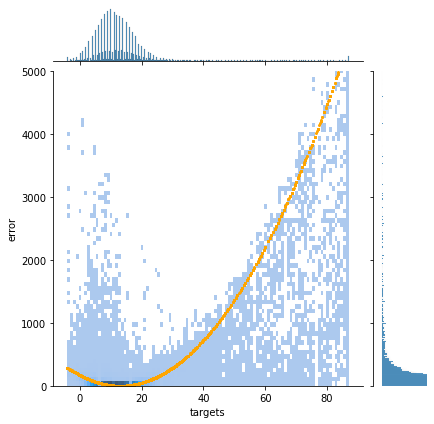

In [16]:
df_nona = df[~df.isna()]
mean_pred_error = (df_nona["targets"] - mean_train_target).dropna() ** 2
ax = sns.jointplot(x="targets", y="error", data=df_nona, kind="hist", bins=100) # data=by_pat
ax.ax_joint.scatter(df_nona["targets"], (np.ones(len(df_nona["targets"])) * mean_train_target - df_nona["targets"]) ** 2, s=2, color="orange")
plt.xlim(-20, 105)
plt.ylim(0, 5000)

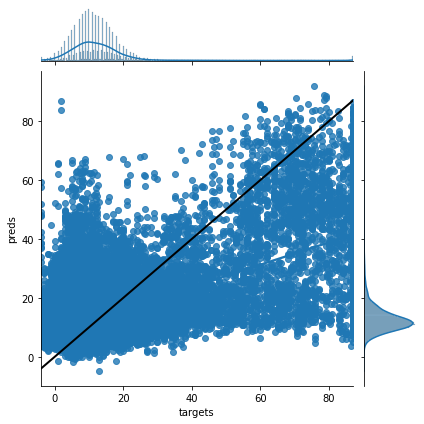

In [17]:
ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
min_val = df_nona["targets"].min()
max_val = df_nona["targets"].max()
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

-4.0 87.0


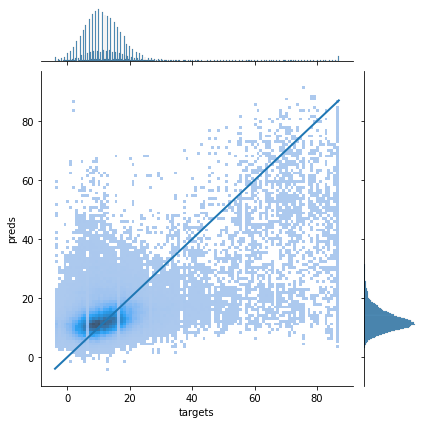

In [18]:
ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="hist", bins=100, ylim=ylim)
print(min_val, max_val)
# draw line of perfect correlation
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [19]:
#pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
pats = df.groupby("ids").filter(lambda x: x['targets'].mean() > 40)
#pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)

pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[ 15  51  84  89 104 110 125 136 144 146 147 149 154 159 169 206 207 224
 230]
19 patients


mean average target:  13.053722766145164
mean pat targets:  60.666666666666664
RMSE of model: 49.61
RMSE of mean: 51.13
MAPE of model:  0.76
MAPE of mean:  0.78


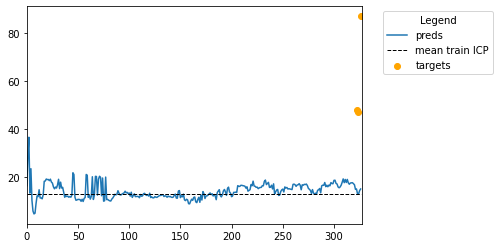

In [20]:
from eval_utils import mape

pat_id = 1
model_id = 0

pat = df[df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train ICP", linestyle="--")
#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
pat_nona = pat[~pat["targets"].isna()]
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

## Saliency

In [23]:
import shap


def classical_saliency(models, trainers, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    for model, data_module in zip(models, trainers):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.test_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    mean_importances = np.mean(np.stack(all_importances), axis=0)
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
        if verbose:
            shap.summary_plot(mean_importances, features=inputs, feature_names=feature_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > 0.2]
    print(len(reduced_df))
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Importance type:  gain


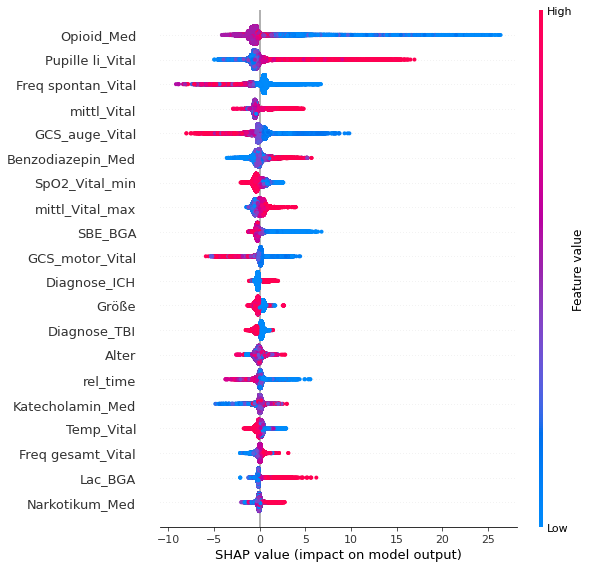

<Figure size 432x288 with 0 Axes>

In [28]:
sal_df = classical_saliency(models, trainers, model_type, use_shap=True, verbose=True)

In [26]:
reduced_feats = reduce_feat_df(sal_df, threshold=0.2)

96
52
ALT_Labor                     0.006903
Kreatinin_Labor               0.006946
mittl_Vital_std               0.007210
INR_Labor                     0.007318
Direkter Vasodilatator_Med    0.007342
Hb_BGA_BGA                    0.007422
aPTT_Labor                    0.007627
Hk_Labor                      0.007682
Diagnose_MISC                 0.007682
K_BGA                         0.007752
mittl_Vital_min               0.008003
GCS_total_Vital               0.008007
Cl_BGA                        0.008043
Diagnose_Stroke               0.008072
Harnstoff-N_Labor             0.008158
TZ_Labor                      0.008305
Alter                         0.008643
Narkotikum_Med                0.008651
rel_time                      0.008989
diast_Vital_max               0.009303
Ppeak_Vital                   0.009351
syst_Vital_max                0.009406
Größe                         0.009691
Diagnose_SAH                  0.009847
SpO2_Vital_min                0.010104
Gewicht            

In [ ]:
from saliency import get_sal_list

sal_list = []

for model in models:
    model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, ds=model.data_module.test_dataloader().dataset, ig=False)
    sal_list += model_saliency

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
mean_overall = [s.mean(0) for s in sal_list]
feat_saliency = np.sum(mean_overall, axis=0)

In [ ]:
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

In [ ]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))

In [ ]:
p.figure.savefig("importances.jpg", bbox_inches='tight')

In [ ]:
plt.show()

# Tuning

In [50]:
from tune_utils import tune, make_tune_plots
from data_utils import make_split

import importlib
import tune_utils
importlib.reload(tune_utils)
from tune_utils import tune

ImportError: cannot import name 'make_tune_plots' from 'tune_utils' (/home/anton/ICU/icp_prediction/tune_utils.py)

In [42]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [43]:
args["dbs"] = ["UKE"]
args["k_fold"] = 0
args["num_splits"] = 3
args["flat_block_size"] = 0
args["n_trials"] = 100
args["model_type"] = "rf"
args["fill_type"] = "pat_ema"

model_args["max_steps"] = 300

In [37]:
opt_flat_block_size = True
opt_augs = False
opt_fill_type = False

In [38]:
# make dev/test split to test tuning
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)

In [48]:
# tune
study = tune(dev_data, test_data, args, model_args, verbose=False, n_trials=args["n_trials"],
             opt_flat_block_size=opt_flat_block_size, opt_augs=opt_augs, opt_fill_type=opt_fill_type)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2021-09-17 00:08:14,107] Trial 0 failed because of the following error: AttributeError("'SeqDataModule' object has no attribute 'make_flat_arrays'")
Traceback (most recent call last):
  File "/home/anton/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/home/anton/ICU/icp_prediction/tune_utils.py", line 105, in __call__
    self.suggest_hyperparams(trial)
  File "/home/anton/ICU/icp_prediction/tune_utils.py", line 150, in suggest_hyperparams
    dm.make_flat_arrays()
AttributeError: 'SeqDataModule' object has no attribute 'make_flat_arrays'


AttributeError: 'SeqDataModule' object has no attribute 'make_flat_arrays'

In [ ]:
# print key study parts
name = study.study_name
print(name)
print(study.best_trial)
best_params = study.best_params
print(best_params)

In [ ]:
make_tune_plots(study, f"outputs/tune_results/{args['model_type']}_{args['n_trials']}")

In [ ]:
# retrain on dev/test and check performance

def retrain(dev_data, test_data, best_params, args, model_args, verbose=True):
    # create splits
    data_modules = do_fold(dev_data, test_data, 
                           args["dbs"], 
                           model_args["random_starts"], 
                           model_args["min_len"], 
                           model_args["train_noise_std"],
                           model_args["bs"],
                           model_args["fill_type"], 
                           args["flat_block_size"],
                           k_fold=0, 
                           num_splits=10,
                          )
    # load best params
    for key in best_params:
        model_args[key] = best_params[key]
    # retrain
    models, trainers = train_model(args["model_type"], data_modules, model_args, verbose=True)
    if verbose:
        # print metrics
        df = get_all_dfs(models, trainers, args["model_type"], dl_type="test")
        print_all_metrics(df)
        loss = df.groupby("model_id").apply(lambda model_df: calc_metric(model_df)).mean()
        print()
        print("Loss: ", loss)
        print("Std of loss: ", df.groupby("model_id").apply(lambda model_df: calc_metric(model_df)).std())

    return models, trainers
    
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

In [ ]:
args["k_fold"] = 0
args["num_splits"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

In [ ]:
args["k_fold"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

## Nested k-fold

In [ ]:
classical_models = ["xgb", "rf", "linear"]

In [ ]:
args["dbs"] = ["UKE"]
args["k_fold"] = 0
args["num_splits"] = 3
args["flat_block_size"] = 1
args["n_trials"] = 100
args["n_outer_folds"] = 3
args["model_type"] = "rnn"
args["fill_type"] = "pat_mean"

In [ ]:
# outer fold
dev_data_list, test_data_list, dev_idcs, test_idcs = make_fold(seq_list, k=args["n_outer_folds"])

In [ ]:
# tune and store studies
studies = []
for dev_data, test_data in zip(dev_data_list, test_data_list):
    study = tune(dev_data, test_data, args, model_args, verbose=False, n_trials=args["n_trials"])
    # print key tune details
    name = study.study_name
    print(name)
    print(study.best_trial)
    best_params = study.best_params
    print(best_params)
    studies.append(study)

In [ ]:
metrics = []
pred_dfs = []
for tune_idx in tqdm(range(len(studies))):
    models, trainers = retrain(dev_data_list[tune_idx],
                               test_data_list[tune_idx], 
                               studies[tune_idx].best_params, 
                               args, model_args, verbose=False)
    df = get_all_dfs(models, trainers, args["model_type"], dl_type="test")
    #loss = print_all_metrics(df)
    loss = df.groupby("model_id").apply(lambda model_df: model_df.groupby("ids").mean()).mean()["error"]
    metrics.append(loss)
    pred_dfs.append(df)
    print(loss)

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
[study.best_value for study in studies]

In [ ]:
metrics

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
metrics

In [ ]:
len(studies)

In [ ]:
studies[0].best_trial